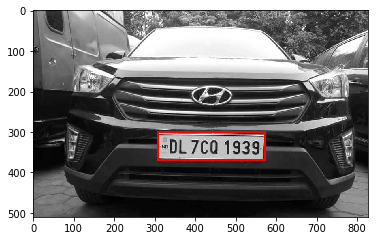

In [21]:
from skimage.io import imread
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import cv2

from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches

i = 1

car_image = imread("car11.jpg", as_grey=True)

while(i!=0):
    
    gray_car_image = car_image
    threshold_value = threshold_otsu(gray_car_image)
    binary_car_image = gray_car_image > threshold_value
    
    label_image = measure.label(binary_car_image)
    
    plate_dimensions = (0.04*label_image.shape[0], 0.5*label_image.shape[0], 0.05*label_image.shape[1], 0.6*label_image.shape[1])
    min_height, max_height, min_width, max_width = plate_dimensions
    plate_objects_cordinates = []
    plate_like_objects = []
    
    for region in regionprops(label_image):
        if region.area < 50:
            
            continue

        # the bounding box coordinates
        min_row, min_col, max_row, max_col = region.bbox
        region_height = max_row - min_row
        region_width = max_col - min_col
        
        if region_width/region_height<7 and max_row<car_image.shape[0] and min_row>car_image.shape[0]/2 and min_col>car_image.shape[1]/4 and max_col<3*car_image.shape[1]/4 and region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
            plate_like_objects.append(binary_car_image[min_row:max_row,min_col:max_col])
            plate_objects_cordinates.append((min_row, min_col, max_row, max_col))
            rectBorder = patches.Rectangle((min_col, min_row), max_col-min_col, max_row-min_row, edgecolor="red", linewidth=2, fill=False)
            i = 0
            fig, (ax1) = plt.subplots(1)
            ax1.imshow(gray_car_image,cmap="gray")
            ax1.add_patch(rectBorder)
            
            plt.show()


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


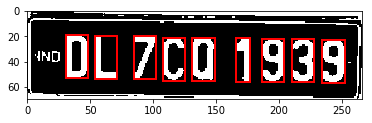

In [23]:
import numpy as np
from skimage.transform import resize
import matplotlib.patches as patches
import matplotlib.pyplot as plt

license_plate = np.invert(plate_like_objects[0])

labelled_plate = measure.label(license_plate)

fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")

character_dimensions = (0.35*license_plate.shape[0], license_plate.shape[0], 0.025*license_plate.shape[1], 0.25*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter=0
column_list = []
for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if x0>5 and x1<license_plate.shape[1]-5 and region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X20 and then append each character into the characters list
        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)

        # this is just to keep track of the arrangement of the characters
        column_list.append(x0)

plt.show()


In [24]:
characters = np.array(characters)

In [25]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from skimage.io import imread
from skimage.filters import threshold_otsu
from pathlib import Path

In [26]:
from skimage.feature import match_template
from skimage.filters import threshold_otsu
from skimage.io import imread
import os.path

# characters that should be clearly examined using template matching
confusing_chars = {'2', 'Z', 'B', '8', 'D', '0', '5', 'S', 'Q', 'R', '7'}

# a dictionary that keeps track of characters that are similar to the
# confusing characters
similar_characters = {
    '2':['Z'], 'Z':['2', '7'], '8':['B'], 'B':['8', 'R'], '5':['S'], 'S':['5'],
    '0':['D', 'Q'], 'D':['0', 'Q'], 'Q':['D', '0'], '7':['Z']
}

def template_match(predicted_label, image_data, training_dir):
    """
    applies the concept of template matching to determine the
    character among the similar ones that have the highest match and
    returns the label

    Parameters:
    ------------
    predicted_label: str; the character that was predicted by the machine
        learning model
    image_data: 2D numpy array image of the character that was predicted
    training_dir: the directory for the images that will be used in matching

    Returns:
    ---------
    The label with the highest match value
    """
    image_data = image_data.reshape(20, 20)
    prediction_fraction = fraction_match(predicted_label, training_dir,
        image_data)
    highest_fraction = prediction_fraction
    highest_fraction_label = predicted_label
    similar_labels_list = similar_characters[predicted_label]

    for each_similar_label in similar_labels_list:
        match_value = fraction_match(each_similar_label, training_dir,
            image_data)
        if match_value > highest_fraction:
            highest_fraction = match_value
            highest_fraction_label = each_similar_label

    return highest_fraction_label
    

def fraction_match(label, training_dir, image_data):
    fraction = 0
    for i in range(10):
        image_dir = os.path.join(training_dir, label, label+'_'+str(i)+'.jpg')
        image_sample = imread(image_dir, as_grey=True)
        image_sample = image_sample < threshold_otsu(image_sample)
        match_fraction = match_template(image_data, image_sample)

        fraction += (match_fraction[0, 0] / 10)
    return fraction

In [27]:
p = Path("./training_data/train20X20")
dirs = p.glob("*")

letters = []
image_data = []
labels = []
image_paths = []
target_data = []

for folder_dir in dirs:
    label = str(folder_dir).split("/")[-1]
    cnt = 0
    letters.append(label)
    print(label,end=' ')
    
def read_training_data(training_directory):
    for each_letter in letters:
        for each in range(10):
            image_path = os.path.join(training_directory, each_letter, each_letter + '_' + str(each) + '.jpg')
            
            img_details = imread(image_path, as_grey=True)
            
            binary_image = img_details < threshold_otsu(img_details)
            
            flat_bin_image = binary_image.reshape(-1)
            image_data.append(flat_bin_image)
            target_data.append(each_letter)
            
    return (np.array(image_data), np.array(target_data))

def cross_validation(model, num_of_fold, train_data, train_label):
    
    accuracy_result = cross_val_score(model, train_data, train_label,
                                      cv=num_of_fold)
    print("Cross Validation Result for ", str(num_of_fold), " -fold")

    print(accuracy_result * 100)

R U 9 0 7 N G 6 Z 1 8 T S A F H M J C D V Q 4 X 3 E B K L 2 Y 5 P W 

In [28]:
training_dataset_dir = p
image_data, target_data = read_training_data(training_dataset_dir)

print(image_data.shape, target_data.shape)

(340, 400) (340,)


In [29]:
svc_model = SVC(kernel='linear', probability=True)

cross_validation(svc_model, 4, image_data, target_data)

svc_model.fit(image_data, target_data)

Cross Validation Result for  4  -fold
[ 96.07843137  99.01960784  97.05882353 100.        ]


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
for each_character in characters:
    each_character = each_character.reshape(1, -1)
    print(each_character.shape)

(1, 400)
(1, 400)
(1, 400)
(1, 400)
(1, 400)
(1, 400)
(1, 400)
(1, 400)
(1, 400)


In [31]:
print(characters.shape)

(9, 20, 20)


In [32]:
current_dir = Path("./")
model_dir = os.path.join(current_dir, 'ml_models/SVC_model/SVC_model.pkl')
model = joblib.load(model_dir)

classification_result = []

cnt = 0
count = 0

for each_character in characters:
    cnt = cnt + 1
    each_character = each_character.reshape(1, -1)
    result = str(model.predict(each_character)[0]).split("'")[1]
    if(result in confusing_chars):
        result = template_match(result,each_character,training_dataset_dir)
        count = count + 1
    if((cnt==1) and (result=='0'or result=='Q')):
        result='D'
    classification_result.append(result)

print(count)
print(classification_result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]

print(plate_string)

# it's possible the characters are wrongly arranged
# since that's a possibility, the column_list will be
# used to sort the letters in the right order

column_list_copy = column_list[:]
column_list.sort()
rightplate_string = ''
for each in column_list:
    rightplate_string += plate_string[column_list_copy.index(each)]

print(rightplate_string)

with open("./model_results/result1","w") as f:
    f.write(rightplate_string)

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator SVC from version pre-0.18 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The file './ml_models/SVC_model/SVC_model.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  This is separate from the ipykernel package so we can avoid doing imports until


3
['D', 'L', 'Z', 'C', 'Q', '1', '9', '3', '9']
DLZCQ1939
DLZCQ1939


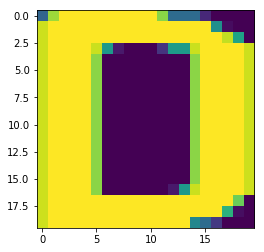

[b'D']


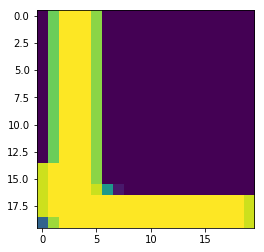

[b'L']


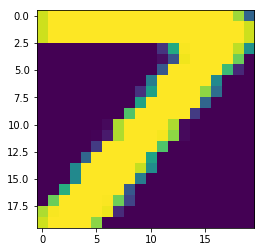

[b'7']


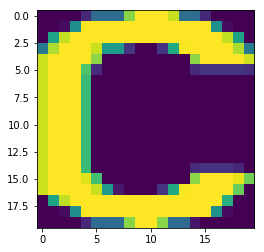

[b'C']


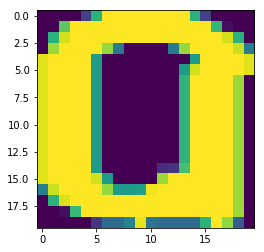

[b'Q']


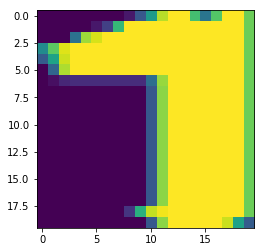

[b'1']


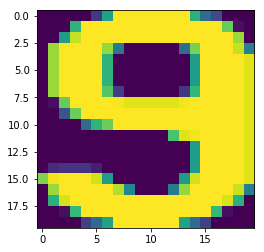

[b'9']


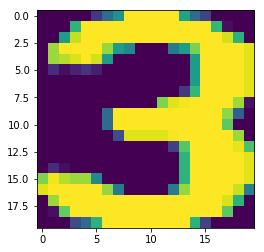

[b'3']


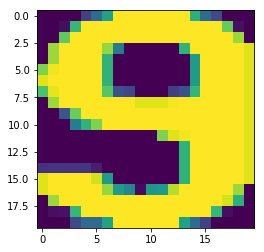

[b'9']


In [33]:
for each_character in characters:
    plt.imshow(each_character)
    plt.show()
    each_character = each_character.reshape(1, -1)
    print(model.predict(each_character))

In [37]:
import geocoder
g = geocoder.ip('me')
lat = g.latlng[0]
lng = g.latlng[1]
print(lat,lng)

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1c24801e10>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))


TypeError: 'NoneType' object is not subscriptable

In [35]:
import json
import datetime

now = datetime.datetime.now()
dati = now.strftime("%Y-%m-%d %H:%M")
time = dati.split(' ')[-1]
date = dati.split(' ')[0]

x = {
  "Number Plate Number": rightplate_string,
  "Latitude": lat,
  "Longitude": lng,
  "Date": date,
  "Time": time
}

y = json.dumps(x)

with open("./model_results/result1.JSON","w") as f:
    f.write(y)


In [36]:
from firebase import firebase 

firebase = firebase.FirebaseApplication('https://god-s-eye-ceba0.firebaseio.com/')
result = firebase.post("/user", y)
print(result)

{'name': '-LW4dvX3KOW8SiNZxkla'}
